# Курс Python для DataScience
# Курсовой проект
## Тема “Real Estate Price Prediction”

Задача в этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).


### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)


### **План курсового проекта**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

## Загрузка данных

### Подключение библиотек и скриптов

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [4]:
# установка единого размера шрифта для всех графиков
matplotlib.rcParams.update({'font.size': 14})

In [5]:
# подсчет метрик для Train и Test
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print(f'Train R2:\t {round(r2(train_true_values, train_pred_values), 3)}')
    print(f'Test R2:\t {round(r2(test_true_values, test_pred_values), 3)}')
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [6]:
# Уменьшение объема памяти, который занимает датасет
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Пути к директориям и файлам

In [7]:
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input\real-estate-price-prediction-moscow.zip
./input\sample_submission.csv
./input\test.csv
./input\train.csv


In [8]:
TRAIN_DATASET_PATH = './input/train.csv'  # /kaggle/input/real-estate-price-prediction-moscow/train.csv
TEST_DATASET_PATH = './input/test.csv'    # ../input/real-estate-price-prediction-moscow/test.csv

In [9]:
t1 = datetime.now()
np.random.seed(seed = 42)

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [10]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [12]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### Приведение типов

In [13]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Качественные показатели переведем к строковому типу:

    Id - идентификационный номер квартиры

Целочисленные показатели переведем к int

    Rooms - количество комнат
    HouseFloor - количество этажей в доме

In [14]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype('int16')
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int16')

### Уменьшение объема памяти, который занимает датасет

In [15]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.41 MB
Memory usage after optimization is: 0.76 MB
Decreased by 46.3%


In [16]:
train_df.dtypes

Id               category
DistrictId          int16
Rooms                int8
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor           int8
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

## 1. EDA  <a class='anchor' id='eda'>

### Целевая переменная

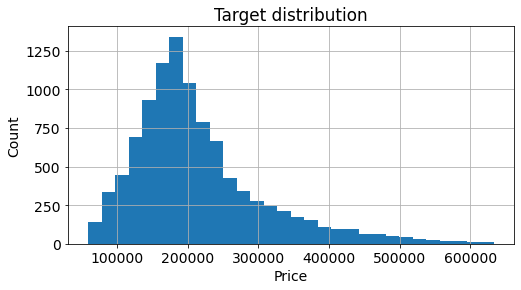

In [17]:
plt.figure(figsize = (8, 4))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

### Количественные переменные

In [18]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


array([[<AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Floor'}>],
       [<AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Social_1'}>],
       [<AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>],
       [<AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

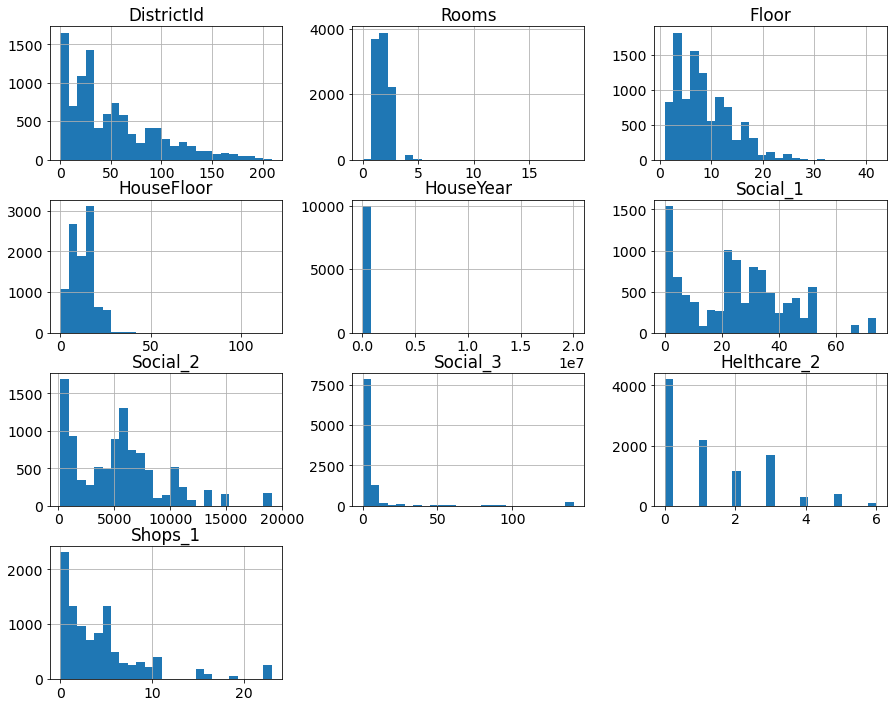

In [19]:
df_num = train_df.select_dtypes(include=['int8', 'int16','int32', 'int64'])
df_num.hist(figsize=(15,12), bins=25, grid=True)

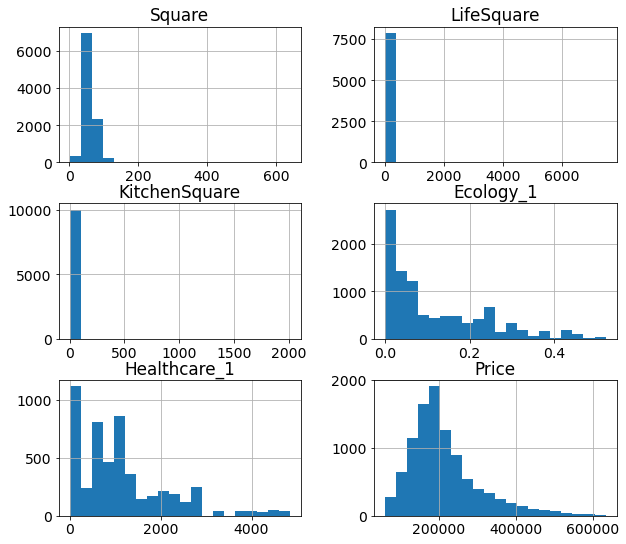

In [20]:
df_num = train_df.select_dtypes(include=['float32','float64'])
#df_num = train_df.select_dtypes(include=['float'])
df_num.hist(figsize=(10,9), bins=20, grid=True);

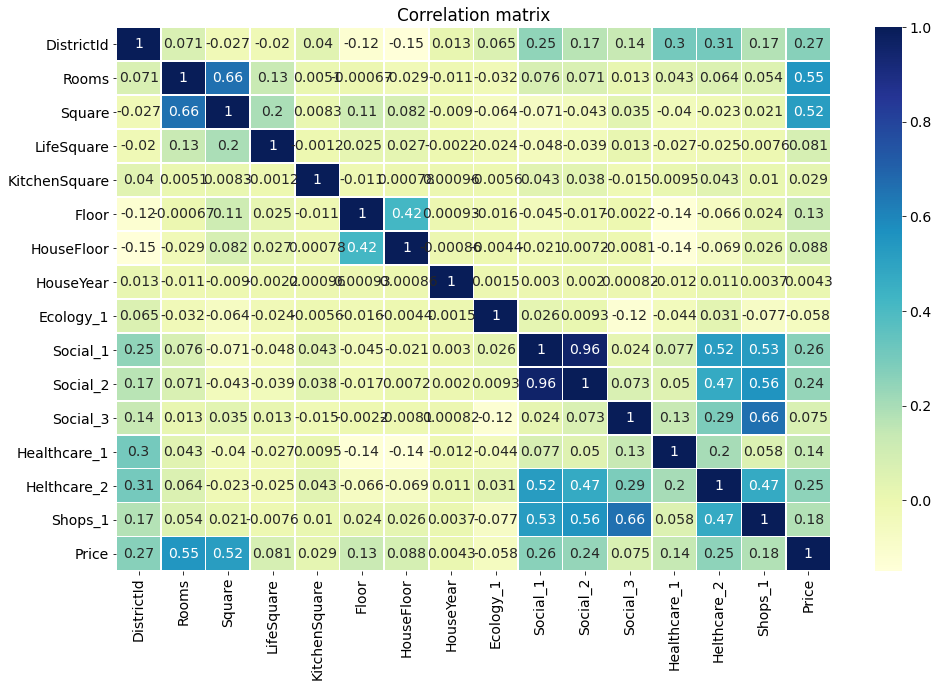

In [21]:
plt.figure(figsize = (16, 10))

sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='YlGnBu')

plt.title('Correlation matrix')
plt.show()

### Номинативные переменные

In [22]:
#train_df.select_dtypes(include='category').columns.tolist() 
train_df.select_dtypes(include='object').columns.tolist() 

[]

In [23]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [24]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [25]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [26]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## 2. Обработка выбросов  <a class='anchor' id='outlier'>

**Rooms**

In [27]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [28]:
# создание вспомогательного признака выброса для числа комнат = 0 или >= 6
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.loc[train_df['Rooms_outlier'] > 0].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.312500,1
2194,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.109375,1
2728,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.265625,1
3780,7317,27,0,41.790882,NaN,0.0,13,0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976562,1
5894,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.343750,1


In [29]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [30]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

In [31]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [32]:
# определим границы выбросов по квантилям 97.5% и 2.5%
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [33]:
train_df.loc[train_df['KitchenSquare'] > 16, 'KitchenSquare'] = 16
train_df.loc[train_df['KitchenSquare'] <= 3, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'].isna(), 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [34]:
train_df['KitchenSquare'].value_counts()

6.0     4221
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
16.0     107
13.0      67
14.0      51
4.0       39
15.0      31
Name: KitchenSquare, dtype: int64

**LifeSquare** 

In [35]:
# определим границы выбросов по квантилям 97.5% и 2.5%
train_df['LifeSquare'].quantile(.975), train_df['LifeSquare'].quantile(.025)

(80.7481, 5.9141297)

In [36]:
train_df.loc[train_df['LifeSquare'] > 80, 'LifeSquare'] = 80
train_df.loc[train_df['LifeSquare'] < 6, 'LifeSquare'] = 6

**HouseFloor, Floor**

In [37]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int8)

In [38]:
train_df['HouseFloor'].value_counts()

17     2331
9      1389
12     1074
5      1031
14      625
16      576
1       497
25      374
22      343
0       269
24      176
8       141
10      135
4       134
3       127
15      123
19      108
20      105
18       89
7        59
6        58
2        48
23       40
21       33
11       28
13       27
30       21
40        7
27        6
32        4
37        4
28        3
99        2
39        2
48        2
38        1
31        1
45        1
117       1
29        1
44        1
36        1
26        1
47        1
Name: HouseFloor, dtype: int64

In [39]:
train_df.loc[train_df['HouseFloor'] == 0].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
24,4717,27,1.0,44.203945,NaN,6.0,2,0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,135466.562500,0
152,12947,53,2.0,56.023342,NaN,6.0,14,0,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,247074.562500,0
159,13146,74,1.0,46.449711,NaN,6.0,6,0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,168705.453125,0
186,12174,62,1.0,44.954880,NaN,6.0,8,0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,133773.296875,0
229,15661,45,3.0,81.094925,NaN,6.0,15,0,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,442472.468750,0


In [40]:
train_df['HouseFloor'].median()

13.0

In [41]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [42]:
train_df['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
37      1
33      1
31      1
Name: Floor, dtype: int64

In [43]:
# значения высоких этажей вполне достоверны - вкладываются в этажность здания
train_df.loc[train_df['Floor'] > 27].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
765,6589,30,1.0,62.110825,52.812126,4.0,31,44,2009,0.000078,...,B,22,6398,141,1046.0,3,23,B,117647.460938,0
1047,11692,113,2.0,70.566574,70.694221,12.0,28,30,2014,0.050756,...,B,24,5469,1,145.0,0,1,B,333862.625000,0
1360,3298,31,1.0,57.551693,21.551876,10.0,32,40,1977,0.151346,...,A,32,5889,10,830.0,4,1,B,393799.531250,0
2383,8016,31,1.0,59.519897,24.050533,10.0,33,40,1977,0.151346,...,A,32,5889,10,830.0,4,1,B,389554.062500,0
4478,4320,29,1.0,47.235844,21.629795,12.0,28,30,2015,0.069660,...,B,31,6119,4,NaN,1,2,B,115651.359375,0


In [44]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [45]:
# создание вспомогательного признака выброса для этажности 
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [46]:
## распределение значений этажа вызывает больше доверия чем значение этажности здания 
train_df.loc[(train_df['HouseFloor'] == 0) & (train_df['Floor'] >= train_df['HouseFloor'].median()), 
             'HouseFloor'] = train_df['Floor']

In [47]:
# этаж больше этажности 
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   24,   25,   26,   33,   34,   37,   39,
            ...
            9921, 9930, 9938, 9940, 9950, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1759)

In [48]:
# если этаж больше этажности поменяем их местами
hf = train_df.loc[floor_outliers,'HouseFloor']
train_df.loc[floor_outliers,'HouseFloor'] = train_df.loc[floor_outliers,'Floor']
train_df.loc[floor_outliers,'Floor'] = hf

In [49]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

In [50]:
train_df.loc[train_df['HouseFloor'] > 60, 'HouseFloor'] = 60

**HouseYear**

In [51]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [52]:
# ограничиваем максимальный год
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [53]:
# ограничиваем минимальный год
train_df.loc[train_df['HouseYear'] < 1920, 'HouseYear'] = 1920

In [54]:
train_df['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1948       2
1941       2
1929       2
1928       1
1947       1
Name: HouseYear, Length: 89, dtype: int64

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [55]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

**LifeSquare**

In [56]:
# создание вспомогательного признака для пропущенной жилой площади 
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['LifeSquare'].median()

**Healthcare_1**

In [57]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
0,11809,27,3.0,115.027313,102.027313,10.0,4,10,2014,0.075424,...,3097,0,NaN,0,0,B,305018.875000,0,0,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.546875,0,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17,1988,0.025609,...,5261,0,240.0,3,1,B,282078.718750,0,0,0
3,2352,1,1.0,40.409908,31.409908,6.0,10,22,1977,0.007122,...,264,0,NaN,0,1,B,168106.000000,0,0,1
4,13866,94,2.0,64.285065,38.562515,9.0,16,16,1972,0.282798,...,8667,2,NaN,0,6,B,343995.093750,0,0,0


In [58]:
# т.к. отсутствует почти половина данных, то этот признак можно удалить
train_df.drop('Healthcare_1', axis=1, inplace=True)

### class DataPreprocessing Подготовка исходных данных

In [59]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 4, 'KitchenSquare'] = 4
        X.loc[X['KitchenSquare'] > 16, 'KitchenSquare'] = 16
        X.loc[X['KitchenSquare'].isna(), 'KitchenSquare'] = X['KitchenSquare'].median()
        
        # LifeSquare
        q025 = X['LifeSquare'].quantile(.025) 
        q975 = X['LifeSquare'].quantile(.975)
        X.loc[X['LifeSquare'] < q025, 'LifeSquare'] = q025
        X.loc[X['LifeSquare'] > q975, 'LifeSquare'] = q975
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X['LifeSquare'].median()
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0 & (X['Floor'] < X['HouseFloor'].median()), 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] == 0 & (X['Floor'] >= X['HouseFloor'].median()), 'HouseFloor'] = X['Floor']

        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        X.loc[X['HouseFloor'] > 60, 'HouseFloor'] = 60
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [60]:
# бинарные признаки
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [61]:
# признак района
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [62]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027313,102.027313,10.0,4,10,2014,0.075424,...,3097,0,0,0,1,305018.875000,0,0,1,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8,1966,0.118537,...,6207,1,1,0,1,177734.546875,0,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17,1988,0.025609,...,5261,0,3,1,1,282078.718750,0,0,0,652
3,2352,1,1.0,40.409908,31.409908,6.0,10,22,1977,0.007122,...,264,0,0,1,1,168106.000000,0,0,1,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16,1972,0.282798,...,8667,2,0,6,1,343995.093750,0,0,0,89


In [63]:
# признак большого района
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [64]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [65]:
train_df['Rooms']

0       3.0
1       1.0
2       3.0
3       1.0
4       2.0
       ... 
9995    2.0
9996    2.0
9997    1.0
9998    1.0
9999    1.0
Name: Rooms, Length: 10000, dtype: float64

In [66]:
# создаем признак от целевой переменной: группируем по району и количеству комнат и берем медианную цену
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [67]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10,2014,0.075424,...,0,0,1,305018.875000,0,0,1,851,1,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8,1966,0.118537,...,1,0,1,177734.546875,0,0,0,78,0,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17,1988,0.025609,...,3,1,1,282078.718750,0,0,0,652,1,244005.281250
3,2352,1,1.0,40.409908,31.409908,6.0,10,22,1977,0.007122,...,0,1,1,168106.000000,0,0,1,652,1,146735.671875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16,1972,0.282798,...,0,6,1,343995.093750,0,0,0,89,0,201584.437500


**MedPriceByFloorYear**

In [68]:
# создание категориц этажности и года постройки
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X

def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [69]:
# labels=False
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1.0
1       2.0
2       0.0
3       3.0
4       4.0
       ... 
9995    0.0
9996    3.0
9997    0.0
9998    0.0
9999    2.0
Name: Floor, Length: 10000, dtype: float64

In [70]:
# labels=True
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [71]:
train_df = year_to_cat_pandas(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027313,102.027313,10.0,4,10,2014,0.075424,...,1,305018.875000,0,0,1,851,1,213530.781250,5,2
1,3013,22,1.0,39.832523,23.169222,8.0,7,8,1966,0.118537,...,1,177734.546875,0,0,0,78,0,146032.828125,2,3
2,8215,1,3.0,78.342216,47.671970,10.0,2,17,1988,0.025609,...,1,282078.718750,0,0,0,652,1,244005.281250,3,1
3,2352,1,1.0,40.409908,31.409908,6.0,10,22,1977,0.007122,...,1,168106.000000,0,0,1,652,1,146735.671875,2,4
4,13866,94,2.0,64.285065,38.562515,9.0,16,16,1972,0.282798,...,1,343995.093750,0,0,0,89,0,201584.437500,2,5


In [72]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,1,380359.12500
1,0,2,324303.81250
2,0,3,422668.37500
3,0,4,274992.46875
4,1,1,467230.53125


In [73]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027313,102.027313,10.0,4,10,2014,0.075424,...,305018.875000,0,0,1,851,1,213530.781250,5,2,161825.406250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8,1966,0.118537,...,177734.546875,0,0,0,78,0,146032.828125,2,3,193455.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17,1988,0.025609,...,282078.718750,0,0,0,652,1,244005.281250,3,1,205210.062500
3,2352,1,1.0,40.409908,31.409908,6.0,10,22,1977,0.007122,...,168106.000000,0,0,1,652,1,146735.671875,2,4,184362.468750
4,13866,94,2.0,64.285065,38.562515,9.0,16,16,1972,0.282798,...,343995.093750,0,0,0,89,0,201584.437500,2,5,177875.703125


### class FeatureGenetator() Генерация новых фич

In [74]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [75]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [76]:
#feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
#                 'Helthcare_2', 'Shops_1', 'Shops_2']

#new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
#                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

# выбор признаков
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
                  'HouseYear', 'Ecology_1', 'Social_3', 'Shops_1']

new_feature_names = ['DistrictSize', 'IsDistrictLarge']

target_name = 'Price'

### Стандартизация признаков

In [77]:
def X_standard(X):
    scaler = StandardScaler()
    features_for_scale = ['Square', 'LifeSquare', 'KitchenSquare','Ecology_1', 'Social_3', 'Shops_1']
    
    X_scaled = scaler.fit_transform(X[features_for_scale])
    X_scaled = pd.DataFrame(X_scaled, columns=features_for_scale)
    X[features_for_scale] = X_scaled
    return X

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [78]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=21)

In [80]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 22), (2000, 22), (5000, 22))

In [81]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 29), (2000, 29), (5000, 29))

In [82]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [83]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [84]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rooms            2000 non-null   float64
 1   Square           2000 non-null   float64
 2   LifeSquare       2000 non-null   float64
 3   KitchenSquare    2000 non-null   float64
 4   Floor            2000 non-null   int64  
 5   HouseYear        2000 non-null   int64  
 6   Ecology_1        2000 non-null   float64
 7   Social_3         2000 non-null   int64  
 8   Shops_1          2000 non-null   int64  
 9   DistrictSize     2000 non-null   int64  
 10  IsDistrictLarge  2000 non-null   int32  
dtypes: float64(5), int32(1), int64(5)
memory usage: 179.7 KB


### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [85]:
# RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=2400, max_depth=20, random_state=100, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=2400, n_jobs=-1,
                      random_state=100)

**Оценка модели**

Train R2:	 0.96
Test R2:	 0.761


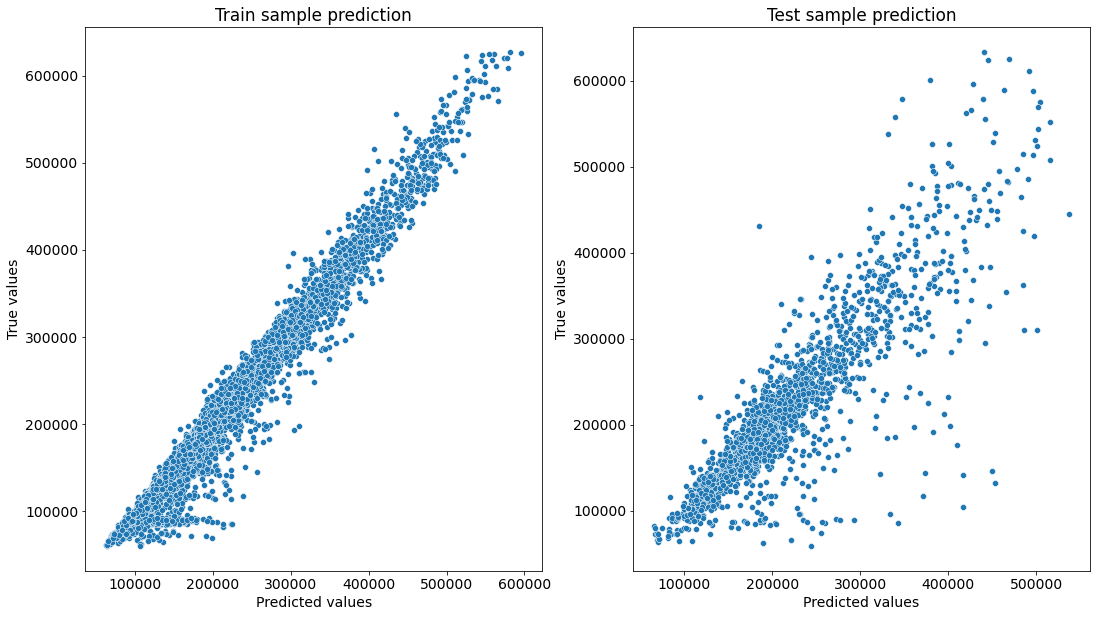

In [86]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Важность признаков**

In [87]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.461125
9,DistrictSize,0.238092
7,Social_3,0.062083
6,Ecology_1,0.050994
5,HouseYear,0.047296
2,LifeSquare,0.040039
4,Floor,0.031337
3,KitchenSquare,0.028426
8,Shops_1,0.025292
0,Rooms,0.014570


### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [88]:
submit = pd.read_csv('./sample_submission.csv')

predictions = rf_model.predict(test_df)

submit['Price'] = predictions
submit.to_csv('rf_submit.csv', index=False)